# Capstone Week 2
---

# Index
- [Capstone Objectives](#Capstone-Objectives)
- [Read in Data](#Read-in-Data)
    - [Merge 2018 and 2019](#Merge-2018-and-2019)
    - [Make advisor dictionary mapper](#Make-advisor-dictionary-mapper)
- [Data Cleaning](#Data-Cleaning)
    - [Train-Test-Split](#Train-Test-Split)
    - [Custom Cleaning Functions](#Custom-Cleaning-Functions)
    - [Create Cleaning Pipeline](#Create-Cleaning-Pipeline)
- [Model building](#Model-building)
- [Make predictions](#Make-predictions)
- [Feature Engineering](#Feature-Engineering)
    - [Variable Inflation Factor (VIF)](#Variable-Inflation-Factor-(VIF))
- [Residuals](#Residuals)
- [Classification](#Classification)
- [Model Interpretation](#Model-Interpretation)

# Capstone Objectives
- Assist sales and marketing by improving their targeting
- Predict sales for 2019 using the data for 2018
- Estimate the probability of adding a new fund in 2019

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

pd.set_option('display.max_columns', 50)

[Back to Top](#Index)
# Read in Data

In [2]:
df18 = pd.read_excel("Transaction Data.xlsx", sheet_name='Transactions18')
df19 = pd.read_excel("Transaction Data.xlsx", sheet_name='Transactions19')
firms = pd.read_excel("Firm Information.xlsx", header=1)

## Merge 2018 and 2019

In [3]:
df = pd.merge(
    df18,
    df19,
    on='CONTACT_ID',
    suffixes=['_2018', '_2019']
)
df.head()

CONTACT_ID  no_of_sales_12M_1  no_of_Redemption_12M_1  \
0               0047433               21.0                    38.0   
1               4461312                NaN                     NaN   
2               4491079                NaN                     NaN   
3               0107408               20.0                     NaN   
4  85101140503769936458                NaN                     NaN   

   no_of_sales_12M_10K  no_of_Redemption_12M_10K  no_of_funds_sold_12M_1  \
0                  NaN                       1.0                     5.0   
1                  NaN                       NaN                     NaN   
2                  NaN                       NaN                     NaN   
3                  2.0                       NaN                     1.0   
4                  NaN                       NaN                     NaN   

   no_of_funds_redeemed_12M_1  no_of_fund_sales_12M_10K  \
0                         5.0                       NaN   
1                         NaN                       NaN   
2                         NaN                       NaN   
3                         NaN                       1.0   
4                         NaN                       NaN   

   no_of_funds_Redemption_12M_10K  no_of_assetclass_sold_12M_1  \
0                             1.0                          2.0   
1                             NaN                          NaN   
2                             NaN                          NaN   
3                             NaN                          1.0   
4                             NaN                          NaN   

   no_of_assetclass_redeemed_12M_1  no_of_assetclass_sales_12M_10K  \
0                              2.0                             NaN   
1                              NaN                             NaN   
2                              NaN                             NaN   
3                              NaN                             1.0   
4                              NaN                             NaN   

   no_of_assetclass_Redemption_12M_10K  No_of_fund_curr  No_of_asset_curr  \
0                                  1.0              8.0               1.0   
1                                  NaN              1.0               1.0   
2                                  NaN              NaN               NaN   
3                                  NaN              1.0               1.0   
4                                  NaN              NaN               NaN   

         AUM  sales_curr  sales_12M_2018  redemption_curr  redemption_12M  \
0  237480.11       250.0         19682.0        -1496.745     -102496.165   
1   19629.00         NaN             NaN              NaN             NaN   
2    1758.70         NaN             NaN              NaN             NaN   
3   57943.00      5459.0         52484.0              NaN             NaN   
4   -8573.59         NaN             NaN              NaN             NaN   

   new_Fund_added_12M_2018  aum_AC_EQUITY  aum_AC_FIXED_INCOME_MUNI  \
0                      NaN      -47342.32                 284737.93   
1                      NaN           0.00                  19629.00   
2                      NaN           0.00                   1758.70   
3                      1.0           0.00                      0.00   
4                      NaN       -8573.59                      0.00   

   aum_AC_FIXED_INCOME_TAXABLE  aum_AC_MONEY  aum_AC_MULTIPLE  \
0                         84.5           0.0              0.0   
1                          0.0           0.0              0.0   
2                          0.0           0.0              0.0   
3                      57943.0           0.0              0.0   
4                          0.0           0.0              0.0   

   aum_AC_PHYSICAL_COMMODITY  aum_AC_REAL_ESTATE  aum_AC_TARGET  aum_P_529  \
0                        0.0                 0.0            0.0        0.0   
1                        0.0                 0.0            0.

## Make advisor dictionary mapper

In [4]:
adviser_lookup = {
    idx: contact_id 
        for idx, contact_id in enumerate(df['CONTACT_ID'])
}

In [5]:
adviser_lookup[10]

'85102150753418532658'

[Back to Top](#Index)
# Data Cleaning

In [6]:
# make a variable to keep all of the columns we want to drop
COLS_TO_DROP = [
    'refresh_date_2019', 'refresh_date_2018', 'CONTACT_ID',
]

COLS_TO_KEEP = [
    'no_of_sales_12M_1', 'no_of_Redemption_12M_1', 'no_of_sales_12M_10K',
    'no_of_Redemption_12M_10K', 'no_of_funds_sold_12M_1',
    'no_of_funds_redeemed_12M_1', 'no_of_fund_sales_12M_10K',
    'no_of_funds_Redemption_12M_10K', 'no_of_assetclass_sold_12M_1',
    'no_of_assetclass_redeemed_12M_1', 'no_of_assetclass_sales_12M_10K',
    'no_of_assetclass_Redemption_12M_10K', 'No_of_fund_curr',
    'No_of_asset_curr', 'AUM', 'sales_curr', 'sales_12M_2018',
    'redemption_curr', 'redemption_12M', 'new_Fund_added_12M_2018',
    'aum_AC_EQUITY', 'aum_AC_FIXED_INCOME_MUNI',
    'aum_AC_FIXED_INCOME_TAXABLE', 'aum_AC_MONEY', 'aum_AC_MULTIPLE',
    'aum_AC_PHYSICAL_COMMODITY', 'aum_AC_REAL_ESTATE', 'aum_AC_TARGET',
    'aum_P_529', 'aum_P_ALT', 'aum_P_CEF', 'aum_P_ETF', 'aum_P_MF',
    'aum_P_SMA', 'aum_P_UCITS', 'aum_P_UIT',
]

In [7]:
X = df.drop(['sales_12M_2019', 'new_Fund_added_12M_2019'], axis=1)
y_reg = df['sales_12M_2019']
y_cl = df['new_Fund_added_12M_2019']

## Train-Test-Split

In [8]:
X_train, X_test, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.3, random_state=24
)
y_train_cl, y_test_cl = y_cl[y_train_reg.index], y_cl[y_test_reg.index]

## Custom Cleaning Functions

Let's create functions that do some basic housekeeping

In [9]:
def extract_columns(df):
    '''extract out columns not listed in COLS_TO_DROP variable'''
    cols_to_keep = [col for col in df.columns if col not in COLS_TO_DROP]
    return df.loc[:, cols_to_keep].copy()


def fillna_values(df):
    '''fill nan values with zero'''
    if isinstance(df, type(pd.Series(dtype='float64'))):
        return df.fillna(0)
    num_df = df.select_dtypes(include=['number']).fillna(0)
    non_num_df = df.select_dtypes(exclude=['number'])
    return pd.concat([num_df, non_num_df], axis=1)


def negative_to_zero(series):
    if isinstance(series, type(pd.Series(dtype='float64'))):
        return series.apply(lambda x: max(0, x))
    else:
        return series

[Back to Top](#Index)
## Create Cleaning Pipeline

- Pipeline for target variable
- Pipeline for features

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler

In [11]:
extract_columns_trans = FunctionTransformer(extract_columns)
fillna_values_trans = FunctionTransformer(fillna_values)
negative_to_zero_trans = FunctionTransformer(negative_to_zero)

Make pipeline for regression target variable

In [12]:
targ_pipe_reg = Pipeline([
    ('fillna_values_trans', fillna_values_trans),
    ('negative_to_zero_trans', negative_to_zero_trans)
])

y_train_reg = targ_pipe_reg.fit_transform(y_train_reg.to_frame()).squeeze()
y_test_reg = targ_pipe_reg.transform(y_test_reg.to_frame()).squeeze()

In [13]:
y_test_reg.head()

2052         0.00
2758      5055.19
4334         0.00
9047    100777.23
7001     22500.00
Name: sales_12M_2019, dtype: float64

Transform the classification target

In [14]:
from sklearn.preprocessing import Binarizer

targ_pipe_cl = Pipeline([
    ('fillna_values_trans', fillna_values_trans),
    ('Binarizer', Binarizer(threshold=0))
])

y_train_cl = pd.Series(
    targ_pipe_cl
        .fit_transform(y_train_cl.to_frame())
        .reshape(-1), index=y_train_cl.index)
y_test_cl = pd.Series(
    targ_pipe_cl
        .transform(y_test_cl.to_frame())
        .reshape(-1), index=y_test_cl.index)
y_test_cl

2052    0.0
2758    1.0
4334    0.0
9047    1.0
7001    0.0
       ... 
3541    1.0
785     0.0
7614    0.0
9577    0.0
1086    0.0
Length: 3002, dtype: float64

Create the pipeline for the features

In [15]:
feat_pipe = Pipeline([
    ('extract_columns_trans', extract_columns_trans),
    ('fillna_values_trans', fillna_values_trans),
    ('StandardScaler', StandardScaler()),
])

X_train_prepared = feat_pipe.fit(X_train).transform(X_train)
X_test_prepared = feat_pipe.transform(X_test)

**TRANSFORM** Test set

In [16]:
X_train_prepared = pd.DataFrame(
    X_train_prepared,
    index=X_train.index,
    columns=COLS_TO_KEEP
)

X_test_prepared = pd.DataFrame(
    feat_pipe.transform(X_test),
    index=X_test.index,
    columns=COLS_TO_KEEP
)

In [17]:
X_test_prepared

no_of_sales_12M_1  no_of_Redemption_12M_1  no_of_sales_12M_10K  \
2052          -0.199371               -0.093252            -0.207843   
2758          -0.159635               -0.048462            -0.207843   
4334          -0.199371               -0.097731            -0.207843   
9047           0.118515                0.050076            -0.207843   
7001           0.009242                0.171009            -0.115750   
...                 ...                     ...                  ...   
3541           0.376797                0.112782             1.357732   
785           -0.199371               -0.097731            -0.207843   
7614          -0.199371               -0.097731            -0.207843   
9577          -0.000692               -0.084294            -0.115750   
1086           0.039043               -0.052941             0.160528   

      no_of_Redemption_12M_10K  no_of_funds_sold_12M_1  \
2052                 -0.089515               -0.573977   
2758                 -0.205862               -0.153081   
4334                 -0.205862               -0.573977   
9047                 -0.205862                0.688712   
7001                  0.259524               -0.153081   
...                        ...                     ...   
3541                  0.375870                1.109608   
785                  -0.205862               -0.573977   
7614                 -0.205862               -0.573977   
9577                 -0.205862                0.688712   
1086                  0.143178               -0.153081   

      no_of_funds_redeemed_12M_1  no_of_fund_sales_12M_10K  \
2052                   -0.221485                 -0.430359   
2758                    0.591014                 -0.430359   
4334                   -0.627735                 -0.430359   
9047                    0.591014                 -0.430359   
7001                    1.403513                  0.318971   
...                          ...                       ...   
3541                    0.591014                  1.817630   
785                    -0.627735                 -0.430359   
7614                   -0.627735                 -0.430359   
9577                   -0.221485                  0.318971   
1086                   -0.221485                  0.318971   

      no_of_funds_Redemption_12M_10K  no_of_assetclass_sold_12M_1  \
2052                        0.301512                    -0.784078   
2758                       -0.442232                     0.201190   
4334                       -0.442232                    -0.784078   
9047                       -0.442232                     1.186457   
7001                        1.789002                     0.201190   
...                              ...                          ...   
3541                        1.789002                     2.171725   
785                        -0.442232                    -0.784078   
7614                       -0.442232                    -0.784078   
9577                       -0.442232                     1.186457   
1086                        0.301512                     0.201190   

      no_of_assetclass_redeemed_12M_1  no_of_assetclass_sales_12M_10K  \
2052                         0.083188                       -0.536570   
2758                         1.035094                       -0.536570   
4334                        -0.868718                       -0.536570   
9047                         1.035094                       -0.536570   
7001                         1.035094                        0.858232   
...                               ...                             ...   
3541                         1.987000                        3.647837   
785                         -0.868718                       -0.536570   
7614                        -0.868718                       -0.536570   
9577                         0.083188                        0.858232   
1086                         0.083188                        0.8582

[Back to Top](#Index)
# Model building
- Evaluate baseline model
- Create new models
- Create evaluation function and cross validate

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA, TruncatedSVD
import xgboost as xgb

XGBoostError: XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed (vcomp140.dll or libgomp-1.dll for Windows, libomp.dylib for Mac OSX, libgomp.so for Linux and other UNIX-like OSes). Mac OSX users: Run `brew install libomp` to install OpenMP runtime.
  * You are running 32-bit Python on a 64-bit OS
Error message(s): ['dlopen(/Users/abhinavverma/opt/anaconda3/lib/python3.8/site-packages/xgboost/lib/libxgboost.dylib, 6): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib\n  Referenced from: /Users/abhinavverma/opt/anaconda3/lib/python3.8/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: image not found']


In [21]:
lr = LinearRegression()
lr.fit(X_train_prepared, y_train_reg)

LinearRegression()

In [22]:
from sklearn.model_selection import cross_validate

In [23]:
-cross_validate(
    lr, 
    X_train_prepared, 
    y_train_reg, 
    cv=3, 
    scoring='neg_root_mean_squared_error', 
    return_train_score=True
)['test_score']

array([ 886209.53410888, 1083427.40248929,  718003.88227331])

Make a plot of predictions vs actual

In [24]:
y_test_reg_preds = lr.predict(X_test_prepared)

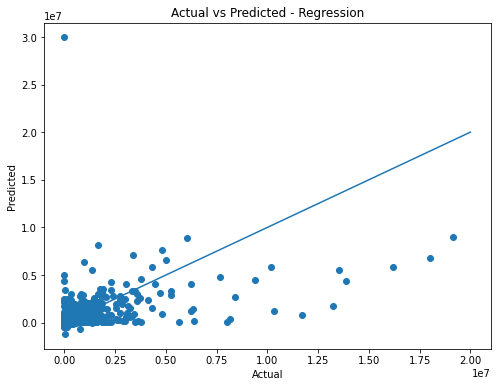

In [25]:
fig, axes = plt.subplots(figsize=(8, 6))

axes.scatter(x=y_test_reg, y=y_test_reg_preds)

axes.plot([0, 20000000], [0,20000000])
axes.set_title("Actual vs Predicted - Regression")
axes.set_xlabel("Actual")
axes.set_ylabel("Predicted");

/Users/abhinavverma/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


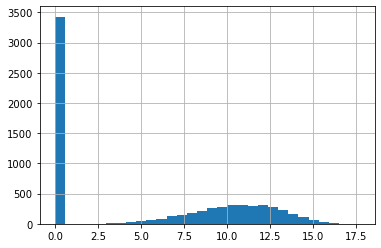

In [26]:
np.log1p(y_train_reg).hist(bins=30);

In [27]:
def evaluate_model(model, X, y):
    print("Cross Validation Scores:")
    print(cross_validate(model, X, y, scoring='neg_root_mean_squared_error')['test_score'])
    print('-'*55)
    preds = model.predict(X)
    lim = max(preds.max(), y.max())
    fig, ax = plt.subplots(1,1,figsize=(7,5))
    ax.scatter(x=y, y=preds, alpha=0.4)
    ax.plot([0, 10000], [0, 10000])
    ax.set_xlim([0, 10000])
    ax.set_ylim([0, 10000])
    ax.set_title("Actual vs Predicted - Regression")
    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted");

Cross Validation Scores:
[ -623859.35974336  -919954.74735948  -689608.43272426 -1622703.48489361
 -5834062.5255059 ]
-------------------------------------------------------


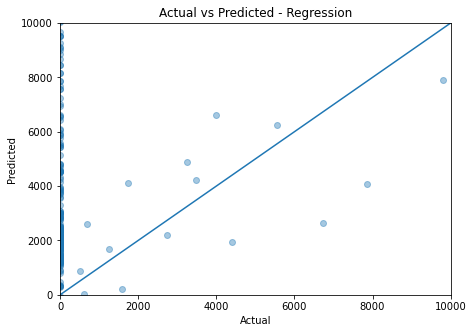

In [28]:
evaluate_model(lr, X_test_prepared, y_test_reg)